In [107]:
import pandas as pd  # Importing the Pandas library for data manipulation and analysis.
import numpy as np  # Importing the NumPy library for numerical computations and array operations.
import matplotlib.pyplot as plt  # Importing the Matplotlib library for data visualization.
import seaborn as sns  # Importing the Seaborn library for creating statistical graphics.
from sklearn.model_selection import train_test_split  # Importing the train_test_split function for splitting data into training and testing subsets.
from sklearn.ensemble import RandomForestClassifier  # Importing the RandomForestClassifier class for building a random forest classifier model.
from sklearn.metrics import accuracy_score  # Importing the accuracy_score function for evaluating classification accuracy.
from sklearn.model_selection import cross_val_score  # Importing the cross_val_score function for performing cross-validation.
from sklearn.model_selection import GridSearchCV  # Importing the GridSearchCV class for hyperparameter tuning using grid search.
from sklearn.metrics import confusion_matrix  # Importing the confusion_matrix function for computing the confusion matrix.
from sklearn.metrics import classification_report  # Importing the classification_report function for generating a classification report.
from sklearn.preprocessing import StandardScaler  # Importing the StandardScaler class for feature scaling.
from sklearn.preprocessing import OneHotEncoder  # Importing the OneHotEncoder class for one-hot encoding categorical features.
from sklearn.compose import ColumnTransformer  # Importing the ColumnTransformer class for applying different transformations to different columns.
from sklearn.pipeline import Pipeline

import shap
import json
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score

from imblearn.over_sampling import SMOTE

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [108]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd

# Set the path to the file you'd like to load
file_path = "Mall_Customers.csv"

# Load the latest version using the recommended function
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "shwetabh123/mall-customers",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 10 records:\n", df.head(10))
print("\nDataFrame Info:\n")
df.info()

Using Colab cache for faster access to the 'mall-customers' dataset.
First 10 records:
    CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
5           6  Female   22                  17                      76
6           7  Female   35                  18                       6
7           8  Female   23                  18                      94
8           9    Male   64                  19                       3
9          10  Female   30                  19                      72

DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Colu

In [109]:
print(f"Number of duplicate rows before handling: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Number of duplicate rows after handling: {df.duplicated().sum()}")

Number of duplicate rows before handling: 0
Number of duplicate rows after handling: 0


In [110]:
print('Missing values before handling:\n', df.isnull().sum())

Missing values before handling:
 CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [111]:
df_cleaned = df.copy()
print("Created a reproducible copy of the DataFrame named 'df_cleaned'.")

Created a reproducible copy of the DataFrame named 'df_cleaned'.


In [112]:
numeric_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
categorical_features = ['Genre']

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop' # Drop 'CustomerID' and any other non-specified columns
)

# Apply transformations
X_processed = preprocessor.fit_transform(df_cleaned)

# Get feature names after one-hot encoding
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(ohe_feature_names)

# Create a DataFrame with the processed features
df_processed = pd.DataFrame(X_processed, columns=all_feature_names)

print("Numeric features scaled and 'Genre' column one-hot encoded. 'CustomerID' column dropped.")
print("First 5 rows of the processed DataFrame:")
print(df_processed.head())

Numeric features scaled and 'Genre' column one-hot encoded. 'CustomerID' column dropped.
First 5 rows of the processed DataFrame:
        Age  Annual Income (k$)  Spending Score (1-100)  Genre_Female  \
0 -1.424569           -1.738999               -0.434801           0.0   
1 -1.281035           -1.738999                1.195704           0.0   
2 -1.352802           -1.700830               -1.715913           1.0   
3 -1.137502           -1.700830                1.040418           1.0   
4 -0.563369           -1.662660               -0.395980           1.0   

   Genre_Male  
0         1.0  
1         1.0  
2         0.0  
3         0.0  
4         0.0  


In [113]:
print("Descriptive statistics for the processed DataFrame:\n", df_processed.describe())

Descriptive statistics for the processed DataFrame:
                 Age  Annual Income (k$)  Spending Score (1-100)  Genre_Female  \
count  2.000000e+02        2.000000e+02            2.000000e+02    200.000000   
mean  -1.021405e-16       -2.131628e-16           -1.465494e-16      0.560000   
std    1.002509e+00        1.002509e+00            1.002509e+00      0.497633   
min   -1.496335e+00       -1.738999e+00           -1.910021e+00      0.000000   
25%   -7.248436e-01       -7.275093e-01           -5.997931e-01      0.000000   
50%   -2.045351e-01        3.587926e-02           -7.764312e-03      1.000000   
75%    7.284319e-01        6.656748e-01            8.851316e-01      1.000000   
max    2.235532e+00        2.917671e+00            1.894492e+00      1.000000   

       Genre_Male  
count  200.000000  
mean     0.440000  
std      0.497633  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000  


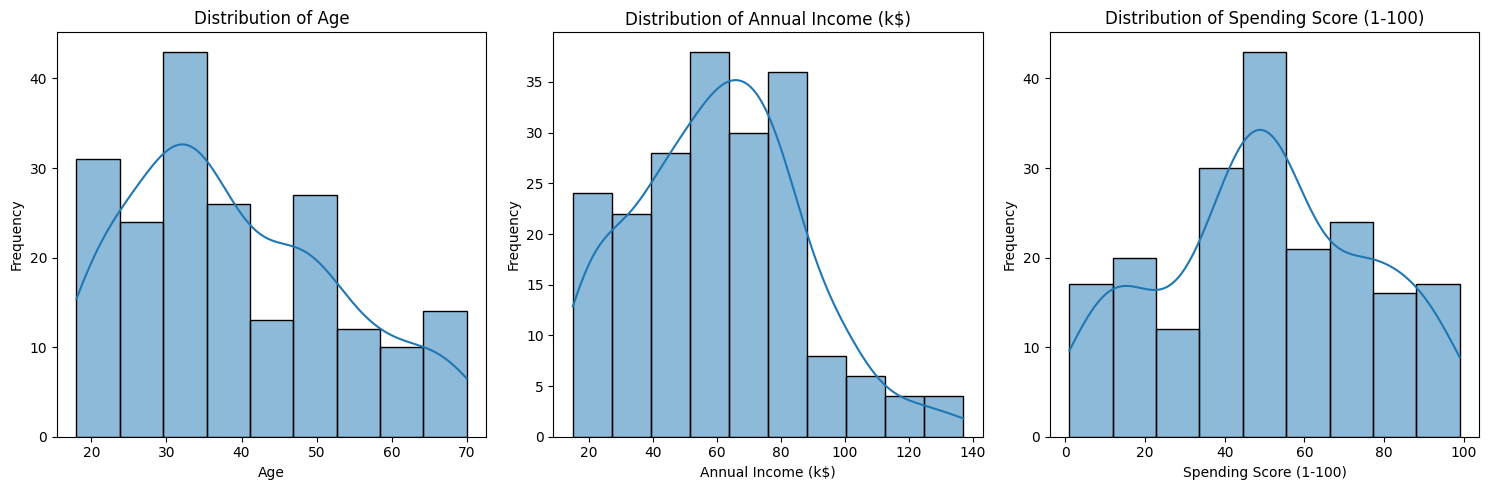

In [114]:
numeric_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

plt.figure(figsize=(15, 5))

for i, feature in enumerate(numeric_features):
    plt.subplot(1, len(numeric_features), i + 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


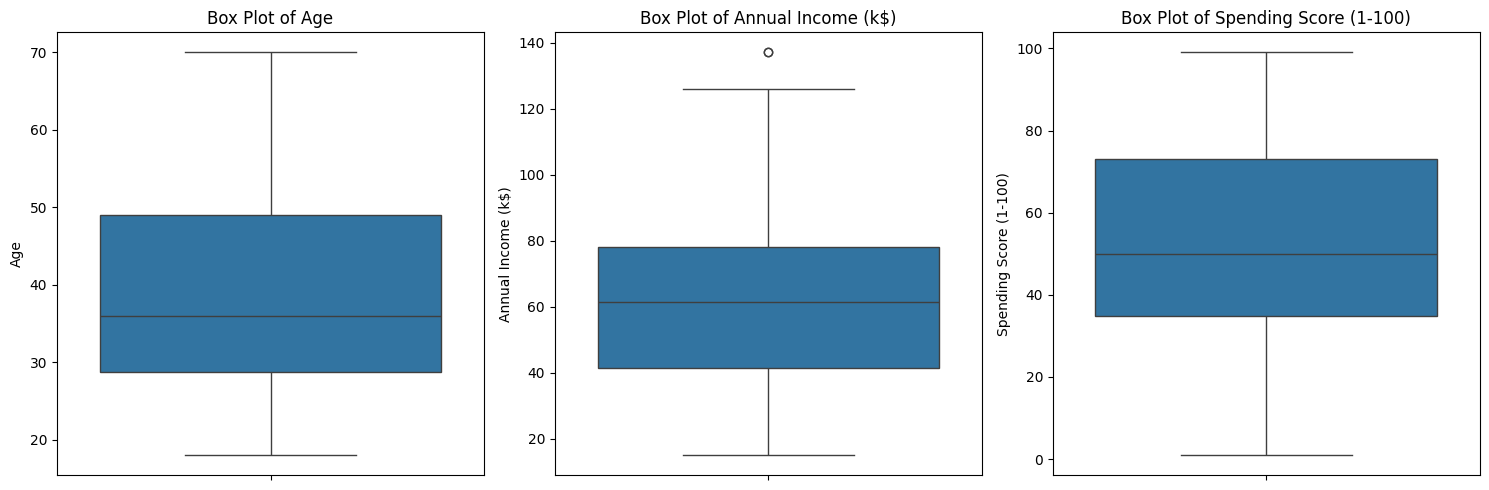

In [115]:
numeric_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

plt.figure(figsize=(15, 5))

for i, feature in enumerate(numeric_features):
    plt.subplot(1, len(numeric_features), i + 1)
    sns.boxplot(y=df[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

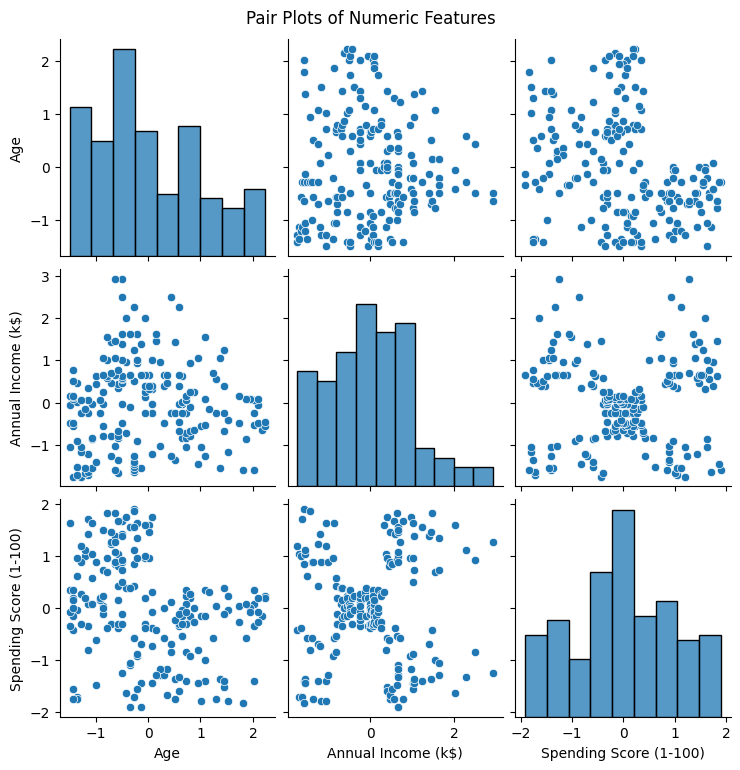

In [116]:
numeric_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
sns.pairplot(df_processed[numeric_features])
plt.suptitle('Pair Plots of Numeric Features', y=1.02) # Add a title to the pair plot
plt.show()

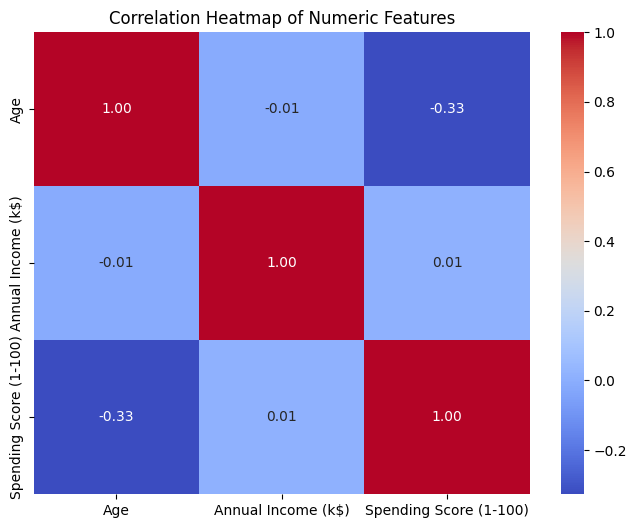

In [117]:
numeric_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Calculate the correlation matrix
correlation_matrix = df_processed[numeric_features].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

In [118]:
import numpy as np

# 1. Create 'Income_to_Spend' feature
df_cleaned['Income_to_Spend'] = df_cleaned['Annual Income (k$)'] / df_cleaned['Spending Score (1-100)']

# Handle potential infinite values if any (though unlikely with current data)
df_cleaned['Income_to_Spend'] = df_cleaned['Income_to_Spend'].replace([np.inf, -np.inf], np.nan)

# 2. Define age bins and labels for 'AgeGroup'
age_bins = [0, 18, 30, 50, np.inf]
age_labels = ['Teenager', 'Young Adult', 'Adult', 'Senior']

# 3. Create the 'AgeGroup' feature
df_cleaned['AgeGroup'] = pd.cut(df_cleaned['Age'], bins=age_bins, labels=age_labels, right=False)

# 4. Display the first few rows of df_cleaned with new features
print("First 5 rows of df_cleaned with new features:")
print(df_cleaned.head())

First 5 rows of df_cleaned with new features:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Income_to_Spend     AgeGroup  
0         0.384615  Young Adult  
1         0.185185  Young Adult  
2         2.666667  Young Adult  
3         0.207792  Young Adult  
4         0.425000        Adult  


In [119]:
import numpy as np

# 1. Define numeric and categorical features for clustering
numeric_features_for_clustering = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_to_Spend']
categorical_features_for_clustering = ['Genre', 'AgeGroup']

# 2. Create a column transformer for preprocessing
preprocessor_clustering = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_for_clustering),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_for_clustering)
    ],
    remainder='drop' # Drop 'CustomerID' and any other non-specified columns
)

# 3. Apply transformations to df_cleaned
X_clustering_processed = preprocessor_clustering.fit_transform(df_cleaned)

# 4. Get feature names after one-hot encoding
ohe_feature_names_clustering = preprocessor_clustering.named_transformers_['cat'].get_feature_names_out(categorical_features_for_clustering)
all_feature_names_clustering = numeric_features_for_clustering + list(ohe_feature_names_clustering)

# 5. Create a DataFrame with the processed features for clustering
df_clustering = pd.DataFrame(X_clustering_processed, columns=all_feature_names_clustering)

print("Data prepared for clustering, including engineered features.")
print("First 5 rows of the df_clustering DataFrame:")
print(df_clustering.head())

Data prepared for clustering, including engineered features.
First 5 rows of the df_clustering DataFrame:
        Age  Annual Income (k$)  Spending Score (1-100)  Income_to_Spend  \
0 -1.424569           -1.738999               -0.434801        -0.304721   
1 -1.281035           -1.738999                1.195704        -0.329632   
2 -1.352802           -1.700830               -1.715913        -0.019667   
3 -1.137502           -1.700830                1.040418        -0.326808   
4 -0.563369           -1.662660               -0.395980        -0.299676   

   Genre_Female  Genre_Male  AgeGroup_Adult  AgeGroup_Senior  \
0           0.0         1.0             0.0              0.0   
1           0.0         1.0             0.0              0.0   
2           1.0         0.0             0.0              0.0   
3           1.0         0.0             0.0              0.0   
4           1.0         0.0             1.0              0.0   

   AgeGroup_Young Adult  
0                   1.0  


In [120]:
from sklearn.cluster import KMeans

# Initialize an empty list to store inertia values
inertia_values = []

# Loop through k values from 2 to 8
for k in range(2, 9):
    # Instantiate KMeans with n_clusters=k, random_state=42, and n_init='auto'
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto')

    # Fit the KMeans model to the df_clustering DataFrame
    kmeans_model.fit(df_clustering)

    # Append the inertia to the inertia_values list
    inertia_values.append(kmeans_model.inertia_)

# Print the inertia_values list
print("Inertia values for k from 2 to 8:", inertia_values)

Inertia values for k from 2 to 8: [856.9388075168483, 674.8451382814821, 499.32906921305937, 396.532236867309, 325.3541114091478, 287.731085780969, 268.23728915073275]


In [121]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

# Initialize empty lists to store the scores
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

# Loop through k values from 2 to 8
for k in range(2, 9):
    # Instantiate KMeans with n_clusters=k, random_state=42, and n_init='auto'
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init='auto')

    # Fit the KMeans model to the df_clustering DataFrame
    kmeans_model.fit(df_clustering)

    # Get the cluster labels for the current k
    labels = kmeans_model.labels_

    # Calculate Silhouette score and append
    silhouette_scores.append(silhouette_score(df_clustering, labels))

    # Calculate Davies-Bouldin score and append
    davies_bouldin_scores.append(davies_bouldin_score(df_clustering, labels))

    # Calculate Calinski-Harabasz score and append
    calinski_harabasz_scores.append(calinski_harabasz_score(df_clustering, labels))

# Print all the collected scores
print("Evaluation Metrics for K-means Clustering (k=2 to 8):")
for i, k in enumerate(range(2, 9)):
    print(f"\nFor k = {k}:")
    print(f"  Inertia: {inertia_values[i]:.2f}")
    print(f"  Silhouette Score: {silhouette_scores[i]:.2f}")
    print(f"  Davies-Bouldin Score: {davies_bouldin_scores[i]:.2f}")
    print(f"  Calinski-Harabasz Score: {calinski_harabasz_scores[i]:.2f}")

Evaluation Metrics for K-means Clustering (k=2 to 8):

For k = 2:
  Inertia: 856.94
  Silhouette Score: 0.25
  Davies-Bouldin Score: 1.73
  Calinski-Harabasz Score: 38.44

For k = 3:
  Inertia: 674.85
  Silhouette Score: 0.26
  Davies-Bouldin Score: 1.61
  Calinski-Harabasz Score: 50.86

For k = 4:
  Inertia: 499.33
  Silhouette Score: 0.26
  Davies-Bouldin Score: 1.21
  Calinski-Harabasz Score: 68.56

For k = 5:
  Inertia: 396.53
  Silhouette Score: 0.30
  Davies-Bouldin Score: 1.09
  Calinski-Harabasz Score: 77.06

For k = 6:
  Inertia: 325.35
  Silhouette Score: 0.32
  Davies-Bouldin Score: 0.99
  Calinski-Harabasz Score: 83.23

For k = 7:
  Inertia: 287.73
  Silhouette Score: 0.33
  Davies-Bouldin Score: 0.97
  Calinski-Harabasz Score: 82.23

For k = 8:
  Inertia: 268.24
  Silhouette Score: 0.32
  Davies-Bouldin Score: 1.04
  Calinski-Harabasz Score: 77.21


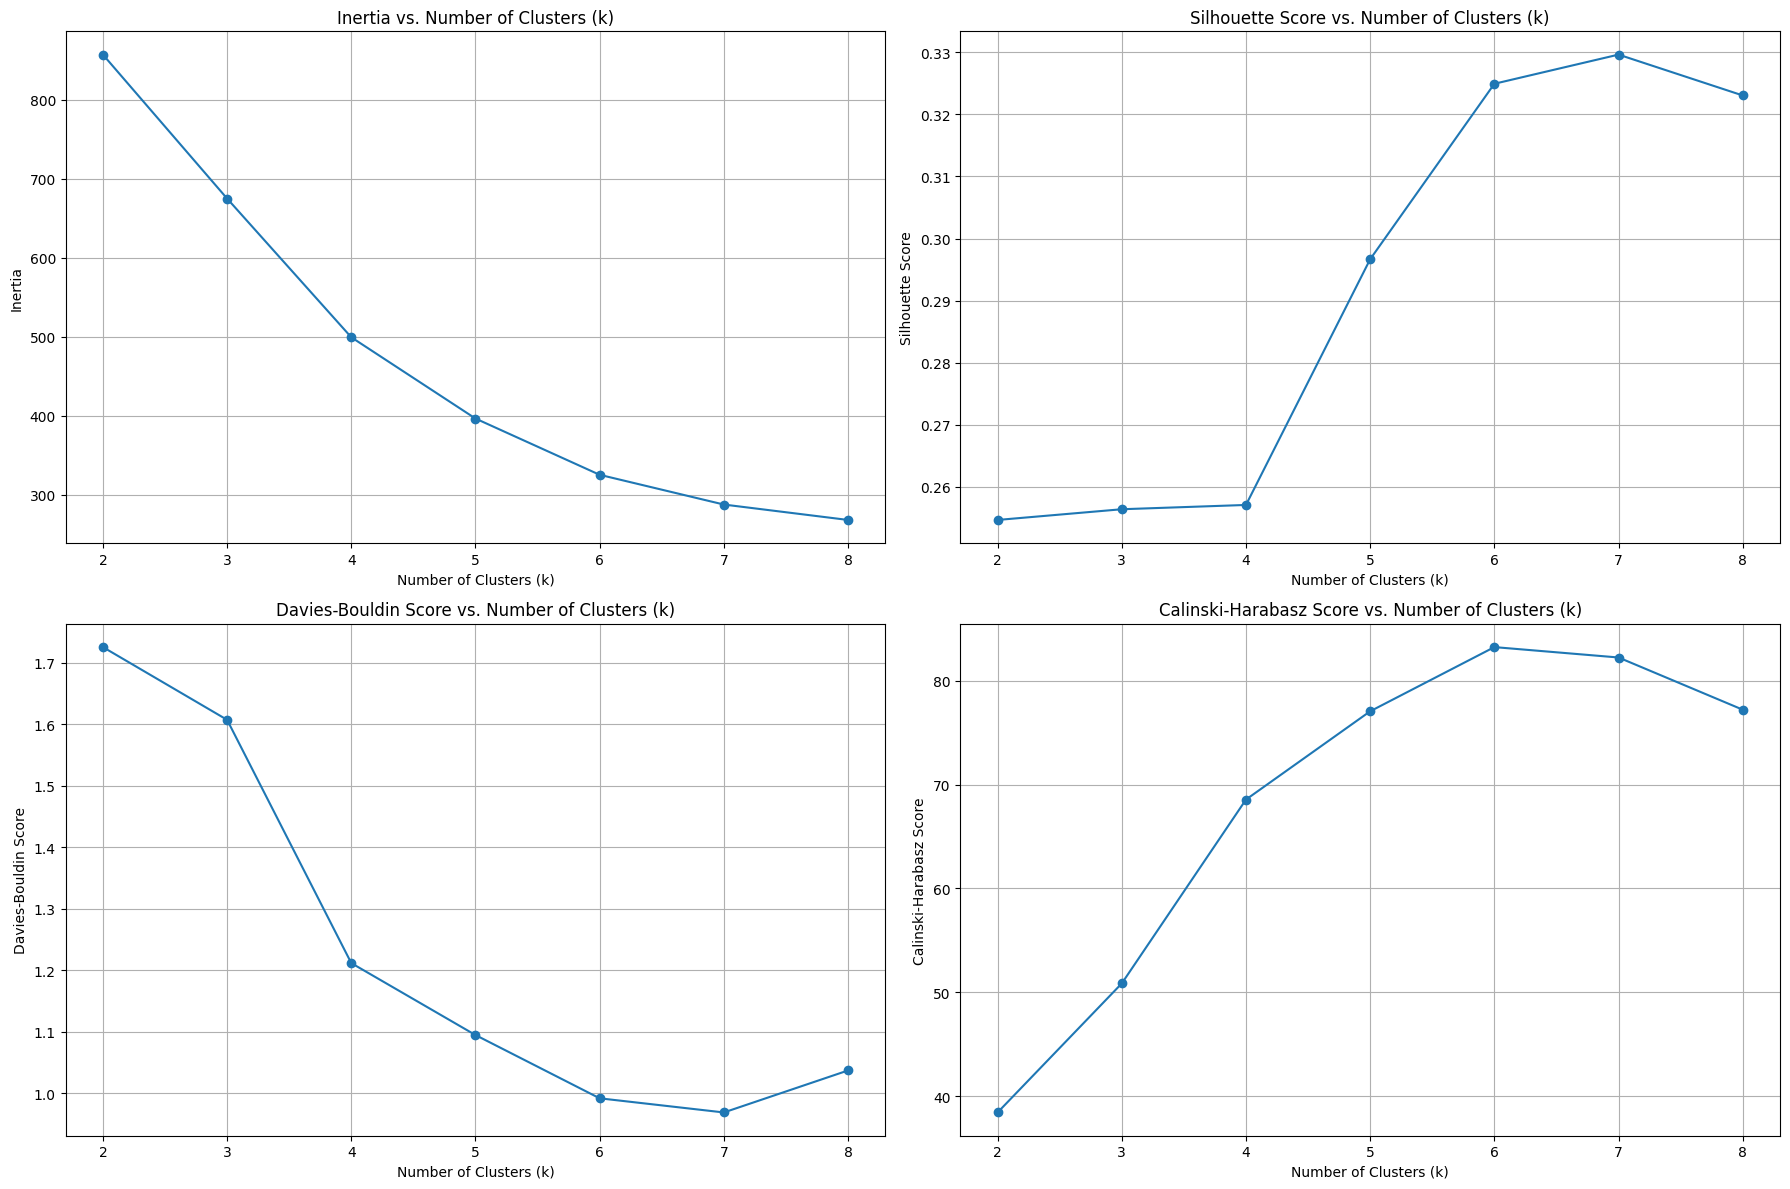

Plots of clustering performance metrics against k values have been generated.


In [122]:
import matplotlib.pyplot as plt

k_values = list(range(2, 9))

plt.figure(figsize=(18, 12))

# Plot Inertia
plt.subplot(2, 2, 1)
plt.plot(k_values, inertia_values, marker='o')
plt.title('Inertia vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)

# Plot Silhouette Score
plt.subplot(2, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Plot Davies-Bouldin Score
plt.subplot(2, 2, 3)
plt.plot(k_values, davies_bouldin_scores, marker='o')
plt.title('Davies-Bouldin Score vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)

# Plot Calinski-Harabasz Score
plt.subplot(2, 2, 4)
plt.plot(k_values, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Score vs. Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)

plt.tight_layout()
plt.show()

print("Plots of clustering performance metrics against k values have been generated.")

## Implement Hierarchical Clustering

Apply AgglomerativeClustering to the preprocessed data (df_clustering) for a range of cluster numbers (2 to 8) and store the cluster assignments.


In [123]:
from sklearn.cluster import AgglomerativeClustering

# Initialize an empty list to store the cluster assignments
hierarchical_labels = []

# Loop through k values from 2 to 8
for k in range(2, 9):
    # Instantiate AgglomerativeClustering model
    agglomerative_model = AgglomerativeClustering(n_clusters=k, linkage='ward')

    # Fit the model and retrieve cluster labels
    labels = agglomerative_model.fit_predict(df_clustering)

    # Append these labels to the hierarchical_labels list
    hierarchical_labels.append(labels)

print("AgglomerativeClustering applied for k values from 2 to 8, and cluster assignments stored.")

AgglomerativeClustering applied for k values from 2 to 8, and cluster assignments stored.



This subtask requires calculating evaluation metrics (Silhouette, Davies-Bouldin, and Calinski-Harabasz scores) for hierarchical clustering, so we will iterate through the generated cluster labels and compute these scores.



In [124]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Initialize empty lists to store the scores for hierarchical clustering
hierarchical_silhouette_scores = []
hierarchical_davies_bouldin_scores = []
hierarchical_calinski_harabasz_scores = []

k_values_for_hierarchy = list(range(2, 9))

# Loop through the stored hierarchical labels (corresponding to k=2 to 8)
for i, labels in enumerate(hierarchical_labels):
    # Calculate Silhouette score and append
    hierarchical_silhouette_scores.append(silhouette_score(df_clustering, labels))

    # Calculate Davies-Bouldin score and append
    hierarchical_davies_bouldin_scores.append(davies_bouldin_score(df_clustering, labels))

    # Calculate Calinski-Harabasz score and append
    hierarchical_calinski_harabasz_scores.append(calinski_harabasz_score(df_clustering, labels))

# Print all the collected scores
print("Evaluation Metrics for Hierarchical Clustering (k=2 to 8):")
for i, k in enumerate(k_values_for_hierarchy):
    print(f"\nFor k = {k}:")
    print(f"  Silhouette Score: {hierarchical_silhouette_scores[i]:.2f}")
    print(f"  Davies-Bouldin Score: {hierarchical_davies_bouldin_scores[i]:.2f}")
    print(f"  Calinski-Harabasz Score: {hierarchical_calinski_harabasz_scores[i]:.2f}")

Evaluation Metrics for Hierarchical Clustering (k=2 to 8):

For k = 2:
  Silhouette Score: 0.24
  Davies-Bouldin Score: 1.67
  Calinski-Harabasz Score: 55.00

For k = 3:
  Silhouette Score: 0.26
  Davies-Bouldin Score: 1.14
  Calinski-Harabasz Score: 64.56

For k = 4:
  Silhouette Score: 0.27
  Davies-Bouldin Score: 1.01
  Calinski-Harabasz Score: 64.09

For k = 5:
  Silhouette Score: 0.28
  Davies-Bouldin Score: 1.12
  Calinski-Harabasz Score: 69.21

For k = 6:
  Silhouette Score: 0.31
  Davies-Bouldin Score: 1.08
  Calinski-Harabasz Score: 76.50

For k = 7:
  Silhouette Score: 0.33
  Davies-Bouldin Score: 0.98
  Calinski-Harabasz Score: 79.22

For k = 8:
  Silhouette Score: 0.33
  Davies-Bouldin Score: 0.96
  Calinski-Harabasz Score: 74.84



This subtask requires generating a dendrogram, which is a visualization of hierarchical clustering that helps in determining the optimal number of clusters. This step involves importing necessary modules and plotting the dendrogram.



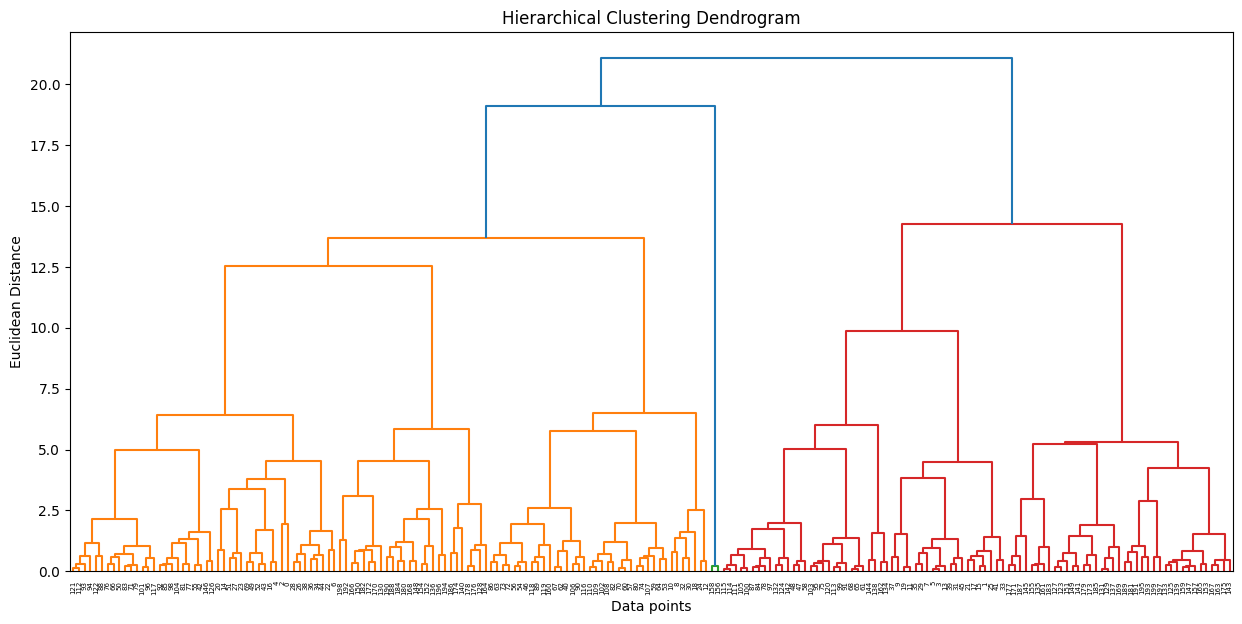

Dendrogram for Hierarchical Clustering generated.


In [125]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix for df_clustering
# We use 'ward' linkage as it was used in AgglomerativeClustering
linked_matrix = linkage(df_clustering, method='ward')

plt.figure(figsize=(15, 7))
dendrogram(
    linked_matrix,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Euclidean Distance')
plt.show()

print("Dendrogram for Hierarchical Clustering generated.")


This subtask requires visualizing the evaluation metrics for hierarchical clustering and comparing them with K-Means clustering. We will create plots for each metric (Silhouette, Davies-Bouldin, Calinski-Harabasz) showing the scores for both clustering methods across different numbers of clusters.



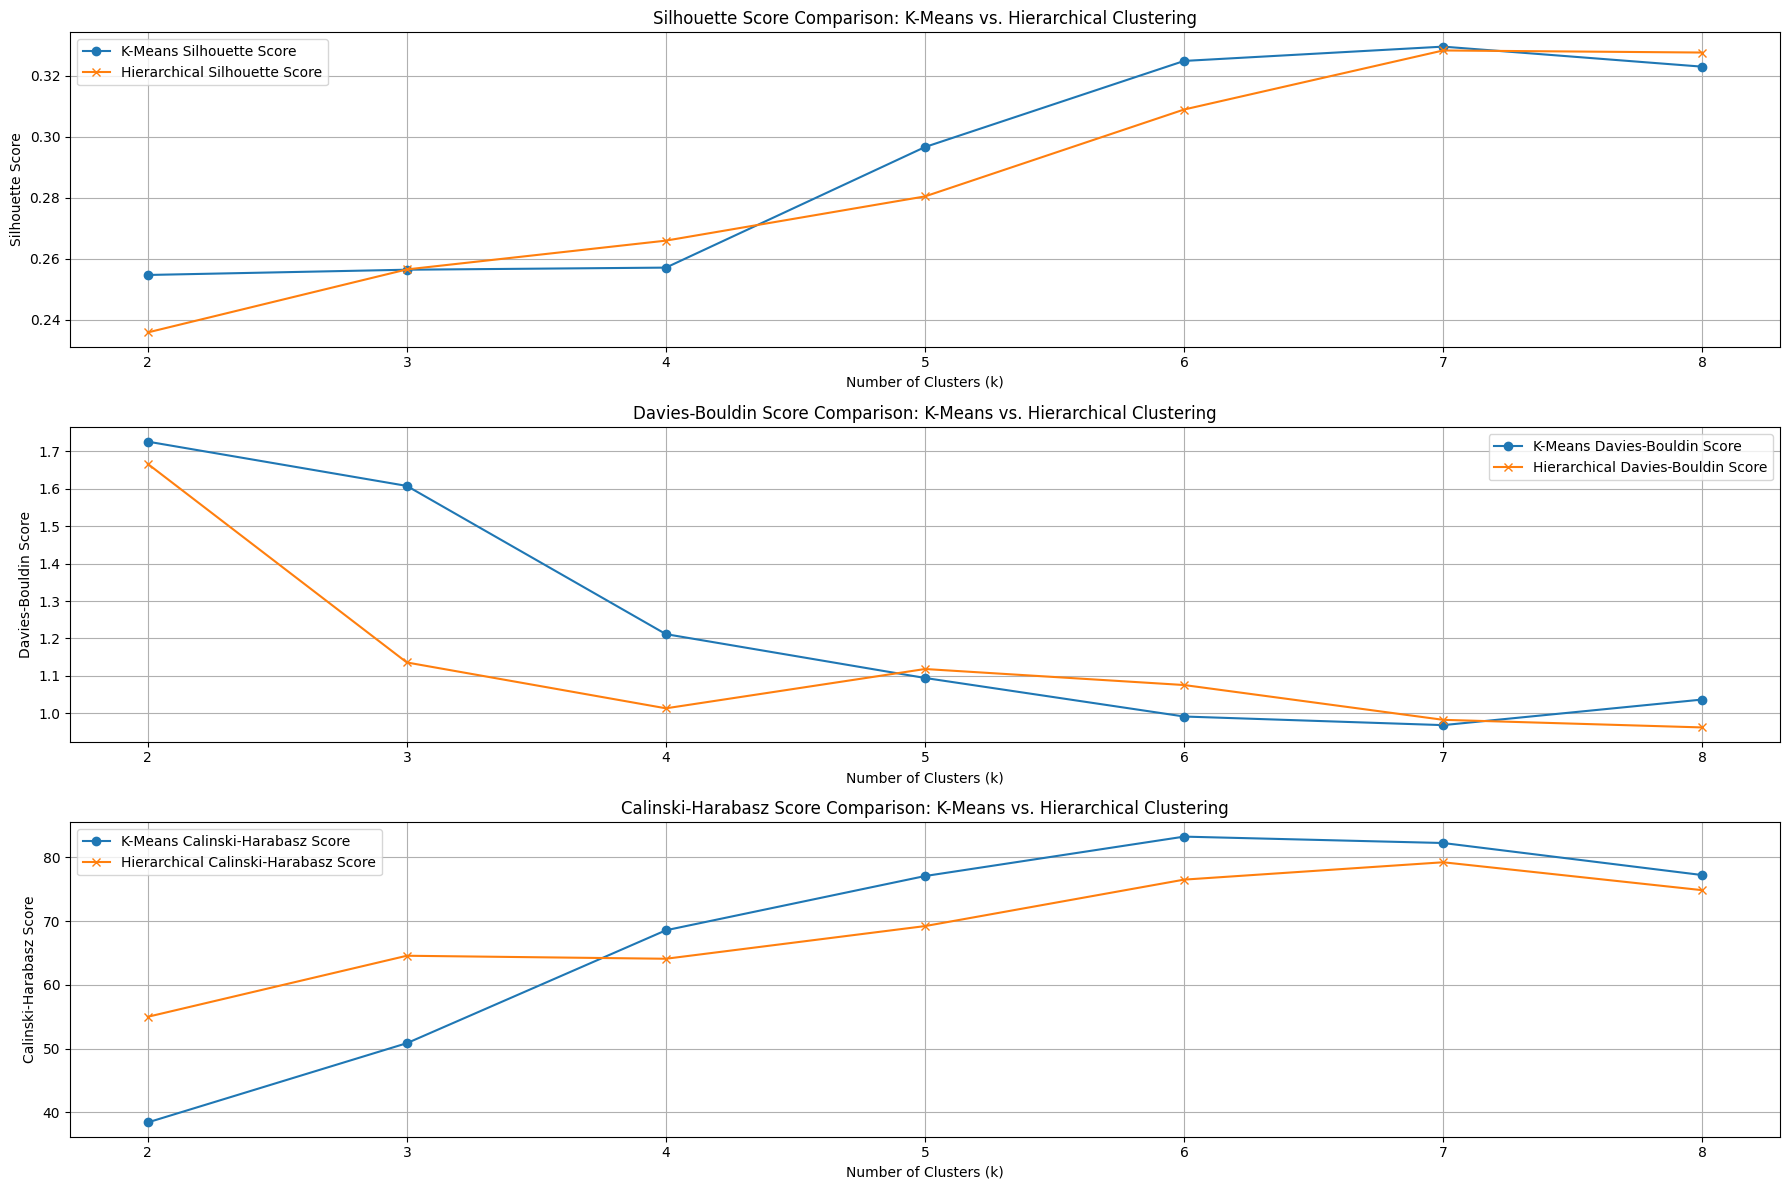

Comparison plots for K-Means and Hierarchical Clustering evaluation metrics generated.


In [126]:
import matplotlib.pyplot as plt

k_values = list(range(2, 9))

plt.figure(figsize=(18, 12))

# Plot Silhouette Score comparison
plt.subplot(3, 1, 1)
plt.plot(k_values, silhouette_scores, marker='o', label='K-Means Silhouette Score')
plt.plot(k_values, hierarchical_silhouette_scores, marker='x', label='Hierarchical Silhouette Score')
plt.title('Silhouette Score Comparison: K-Means vs. Hierarchical Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.legend()

# Plot Davies-Bouldin Score comparison
plt.subplot(3, 1, 2)
plt.plot(k_values, davies_bouldin_scores, marker='o', label='K-Means Davies-Bouldin Score')
plt.plot(k_values, hierarchical_davies_bouldin_scores, marker='x', label='Hierarchical Davies-Bouldin Score')
plt.title('Davies-Bouldin Score Comparison: K-Means vs. Hierarchical Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)
plt.legend()

# Plot Calinski-Harabasz Score comparison
plt.subplot(3, 1, 3)
plt.plot(k_values, calinski_harabasz_scores, marker='o', label='K-Means Calinski-Harabasz Score')
plt.plot(k_values, hierarchical_calinski_harabasz_scores, marker='x', label='Hierarchical Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score Comparison: K-Means vs. Hierarchical Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print("Comparison plots for K-Means and Hierarchical Clustering evaluation metrics generated.")

### Analysis and Summary of Clustering Results

Based on the comparison plots for Silhouette, Davies-Bouldin, and Calinski-Harabasz scores, we can analyze the performance of K-Means and Hierarchical Clustering across different numbers of clusters (k).

**1. Silhouette Score:**
*   **K-Means:** The Silhouette score for K-Means generally increases, peaking at k=7 (0.33) and k=6 (0.32), and then slightly decreasing at k=8 (0.32). This suggests that 6 or 7 clusters might be optimal for K-Means.
*   **Hierarchical Clustering:** Hierarchical clustering also shows an increasing trend, peaking at k=7 (0.33) and k=8 (0.33). Its scores are quite competitive with K-Means.

**2. Davies-Bouldin Score:**
*   **K-Means:** The Davies-Bouldin score for K-Means generally decreases, indicating better clustering, reaching its lowest point at k=7 (0.97) and k=6 (0.99). This also suggests 6 or 7 as potentially optimal for K-Means.
*   **Hierarchical Clustering:** Hierarchical clustering also shows a decreasing trend, reaching its lowest point at k=8 (0.96) and k=7 (0.98). It performs slightly better than K-Means at k=8.

**3. Calinski-Harabasz Score:**
*   **K-Means:** The Calinski-Harabasz score for K-Means increases with 'k', peaking at k=6 (83.23) and remaining high at k=7 (82.23) and k=5 (77.06). This metric suggests 6 clusters as optimal for K-Means.
*   **Hierarchical Clustering:** Hierarchical clustering's Calinski-Harabasz score also increases and peaks at k=7 (79.22) and k=6 (76.50). Its performance is slightly lower than K-Means for the highest values.

**Overall Comparison and Optimal Number of Clusters:**

Both K-Means and Hierarchical Clustering show similar trends in their evaluation metrics. Generally, Hierarchical Clustering tends to achieve slightly better Davies-Bouldin scores at higher 'k' values (e.g., k=8), while K-Means shows a slightly better Calinski-Harabasz score at k=6.

Considering all three metrics, **k=6 or k=7** appears to be a strong candidate for the optimal number of clusters for both algorithms. Specifically:

*   **For K-Means:** `k=6` or `k=7` provide a good balance, with k=6 having the highest Calinski-Harabasz score and strong Silhouette and Davies-Bouldin scores. `k=7` provides the highest Silhouette score and lowest Davies-Bouldin score.
*   **For Hierarchical Clustering:** `k=7` or `k=8` tend to perform best, with `k=7` yielding the highest Calinski-Harabasz score and `k=8` yielding the lowest Davies-Bouldin score.

**Justification for Optimal 'k'**:

Both algorithms demonstrate a good clustering structure around **k=6 or k=7**. Based on the combined view of the metrics:
-   The **Silhouette Score** suggests better-defined clusters with K-Means and Hierarchical clustering peaking at `k=7`.
-   The **Davies-Bouldin Score** (lower is better) points to `k=7` for K-Means and `k=8` for Hierarchical clustering.
-   The **Calinski-Harabasz Score** (higher is better) indicates `k=6` for K-Means and `k=7` for Hierarchical clustering.

## Optimal Clustering Application and Profile Analysis

Apply the optimal K-Means model (k=7) to the preprocessed data, assign cluster labels to the original cleaned DataFrame, and then analyze and visualize the characteristics of each customer segment.


In [127]:
from sklearn.cluster import KMeans

# Instantiate KMeans model with n_clusters=7
kmeans_optimal = KMeans(n_clusters=7, random_state=42, n_init='auto')

# Fit the model to the df_clustering DataFrame
kmeans_optimal.fit(df_clustering)

# Predict the cluster labels
cluster_labels = kmeans_optimal.predict(df_clustering)

# Assign cluster labels to a new 'Cluster' column in the df_cleaned DataFrame
df_cleaned['Cluster'] = cluster_labels

print("KMeans model with k=7 applied and cluster labels assigned to 'df_cleaned'.")
print("First 5 rows of df_cleaned with new 'Cluster' column:")
print(df_cleaned.head())

KMeans model with k=7 applied and cluster labels assigned to 'df_cleaned'.
First 5 rows of df_cleaned with new 'Cluster' column:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Income_to_Spend     AgeGroup  Cluster  
0         0.384615  Young Adult        5  
1         0.185185  Young Adult        5  
2         2.666667  Young Adult        6  
3         0.207792  Young Adult        5  
4         0.425000        Adult        2  


## Calculate Numerical Cluster Statistics

Calculate descriptive statistics (mean and standard deviation) for numerical features ('Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_to_Spend') within each cluster in `df_cleaned`.


In [128]:
numerical_features_to_analyze = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_to_Spend']

# Calculate the mean for each numerical feature within each cluster
cluster_means = df_cleaned.groupby('Cluster')[numerical_features_to_analyze].mean()

print("Mean of numerical features per cluster:")
print(cluster_means)

Mean of numerical features per cluster:
               Age  Annual Income (k$)  Spending Score (1-100)  \
Cluster                                                          
0        59.948718           49.153846               41.820513   
1        44.074074           91.740741               19.444444   
2        41.097561           45.317073               41.439024   
3        35.500000           78.000000                1.000000   
4        32.692308           86.538462               82.128205   
5        24.545455           25.136364               78.363636   
6        22.366667           59.200000               41.866667   

         Income_to_Spend  
Cluster                   
0               1.759578  
1               5.942248  
2               1.278483  
3              78.000000  
4               1.068308  
5               0.327708  
6               2.615595  


we will now calculate the standard deviation for the same numerical features for each cluster.



In [129]:
numerical_features_to_analyze = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_to_Spend']

# Calculate the standard deviation for each numerical feature within each cluster
cluster_stds = df_cleaned.groupby('Cluster')[numerical_features_to_analyze].std()

print("Standard Deviation of numerical features per cluster:")
print(cluster_stds)

Standard Deviation of numerical features per cluster:
              Age  Annual Income (k$)  Spending Score (1-100)  Income_to_Spend
Cluster                                                                       
0        6.715844           14.942941               16.957954         1.885044
1        7.645642           17.064567                9.099169         3.252454
2        6.575731           15.097084               14.681704         0.763975
3        2.121320            0.000000                0.000000         0.000000
4        3.728650           16.312485                9.364489         0.242131
5        4.944716            7.881838               13.069577         0.109400
6        3.537809           13.450804               17.145892         3.788477


Calculate the distribution (value counts or percentages) of categorical features ('Genre', 'AgeGroup') within each cluster.



In [130]:
categorical_features_to_analyze = ['Genre', 'AgeGroup']

print("Distribution of categorical features per cluster:")
for feature in categorical_features_to_analyze:
    print(f"\nFeature: {feature}")
    # Calculate value counts for each category within each cluster
    cluster_category_counts = df_cleaned.groupby('Cluster')[feature].value_counts().unstack(fill_value=0)
    print("Absolute Counts:")
    print(cluster_category_counts)

    # Calculate percentages for each category within each cluster
    cluster_category_percentages = df_cleaned.groupby('Cluster')[feature].value_counts(normalize=True).mul(100).unstack(fill_value=0)
    print("\nPercentages (%):")
    print(cluster_category_percentages.round(2))


Distribution of categorical features per cluster:

Feature: Genre
Absolute Counts:
Genre    Female  Male
Cluster              
0            19    20
1            14    13
2            29    12
3             0     2
4            21    18
5            13     9
6            16    14

Percentages (%):
Genre    Female    Male
Cluster                
0         48.72   51.28
1         51.85   48.15
2         70.73   29.27
3          0.00  100.00
4         53.85   46.15
5         59.09   40.91
6         53.33   46.67

Feature: AgeGroup
Absolute Counts:
AgeGroup  Teenager  Young Adult  Adult  Senior
Cluster                                       
0                0            0      0      39
1                0            0     21       6
2                0            0     41       0
3                0            0      2       0
4                0            8     31       0
5                0           17      5       0
6                0           30      0       0

Percentages (%):
AgeGroup

We will create box plots for each numerical feature, grouped by cluster.



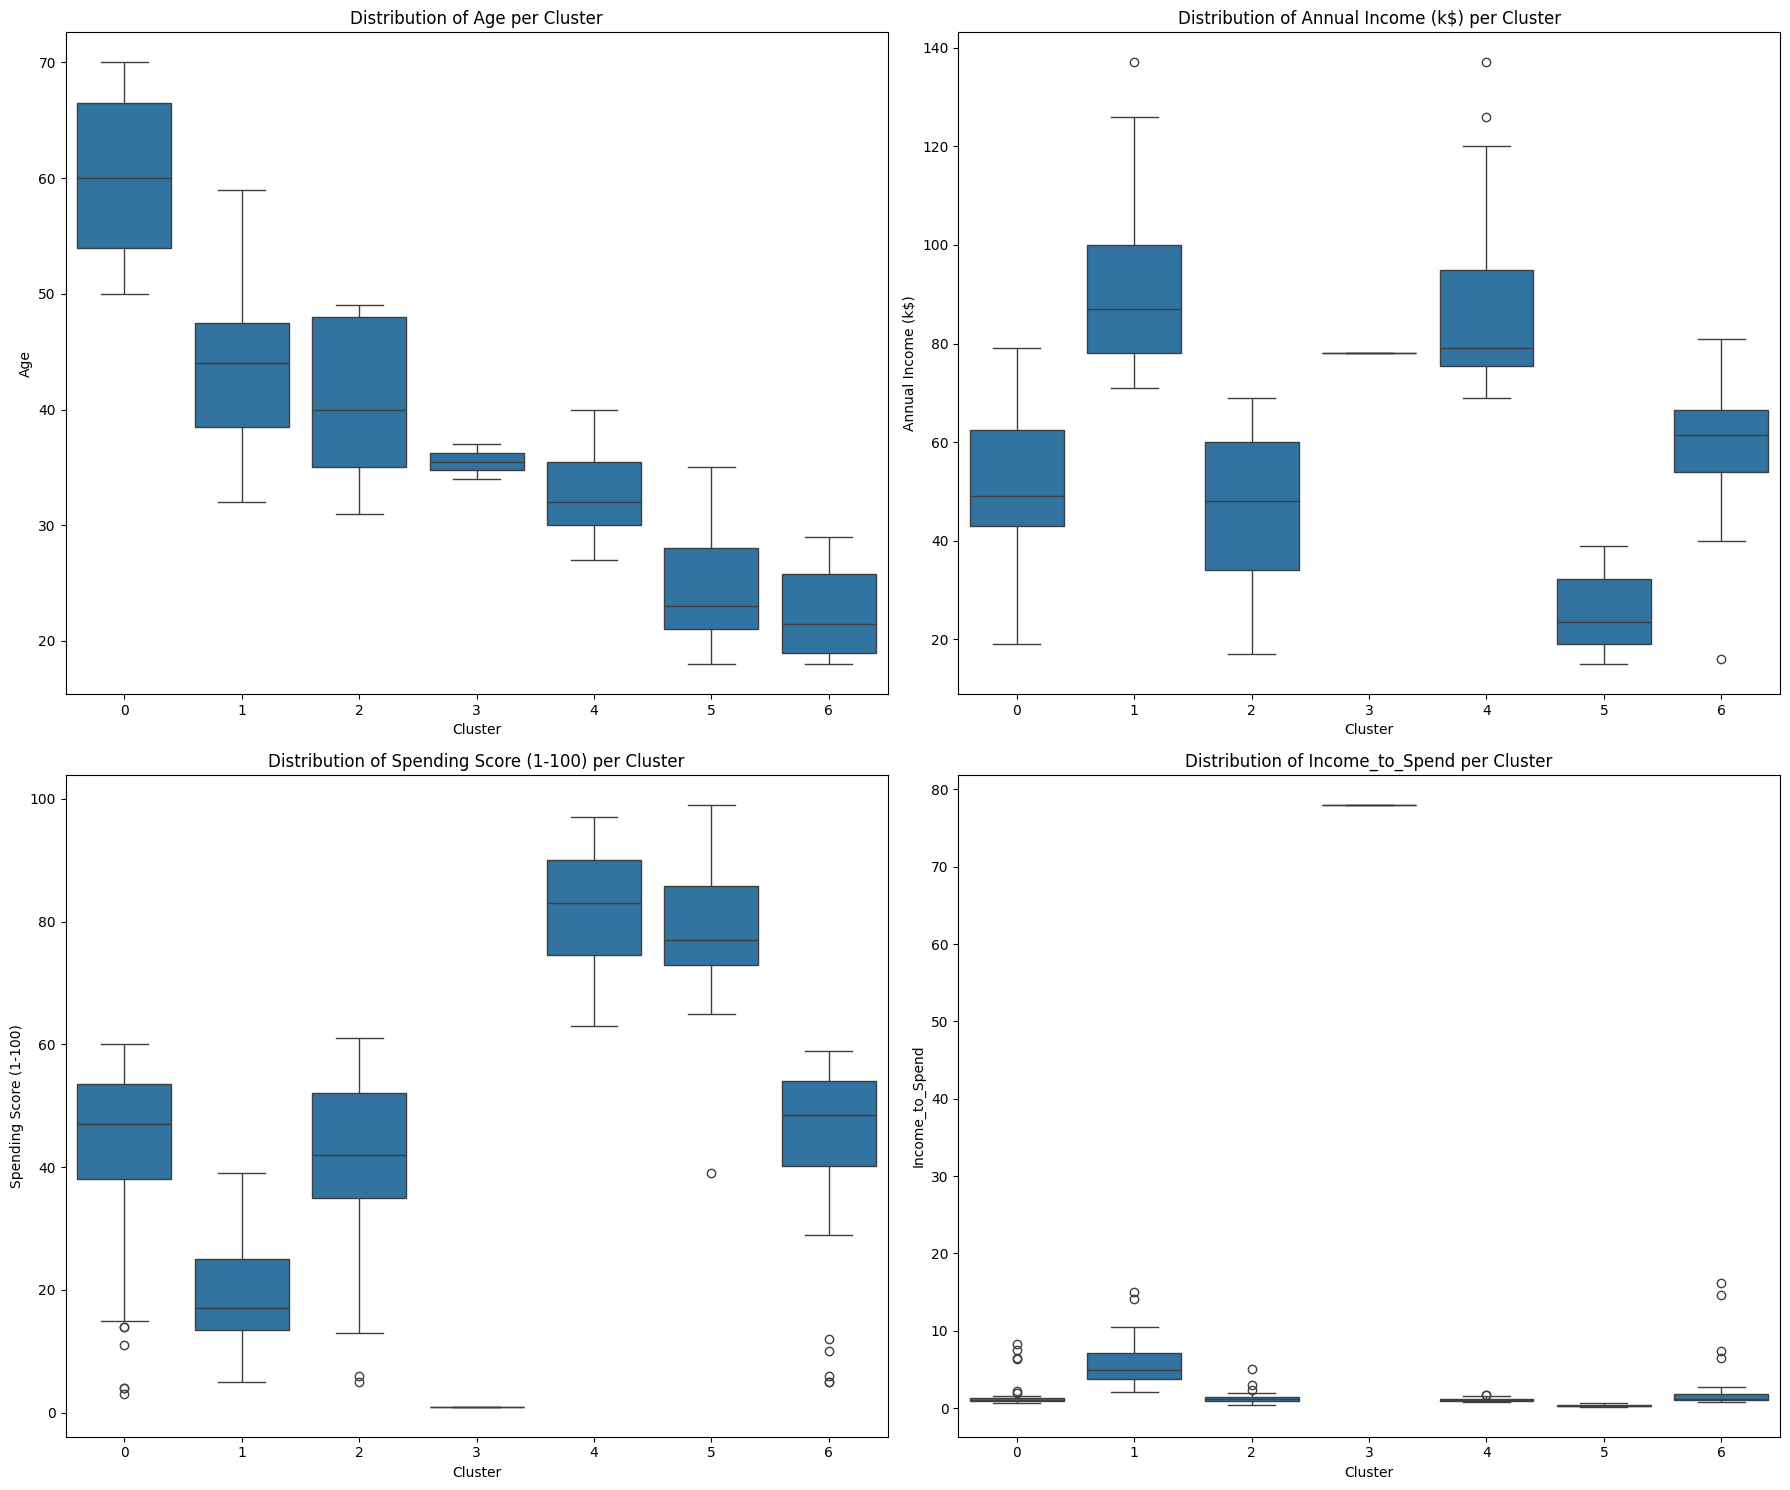

Box plots for numerical features per cluster have been generated.


In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features_to_analyze = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Income_to_Spend']

plt.figure(figsize=(18, 15))

for i, feature in enumerate(numerical_features_to_analyze):
    plt.subplot(2, 2, i + 1) # Arrange plots in a 2x2 grid
    sns.boxplot(x='Cluster', y=feature, data=df_cleaned)
    plt.title(f'Distribution of {feature} per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

print("Box plots for numerical features per cluster have been generated.")

To visually analyze the distributions of categorical features across the identified clusters.Given the nature of 'Genre' (two categories) and 'AgeGroup' (multiple categories), we will create count plots for each categorical feature, grouped by cluster.


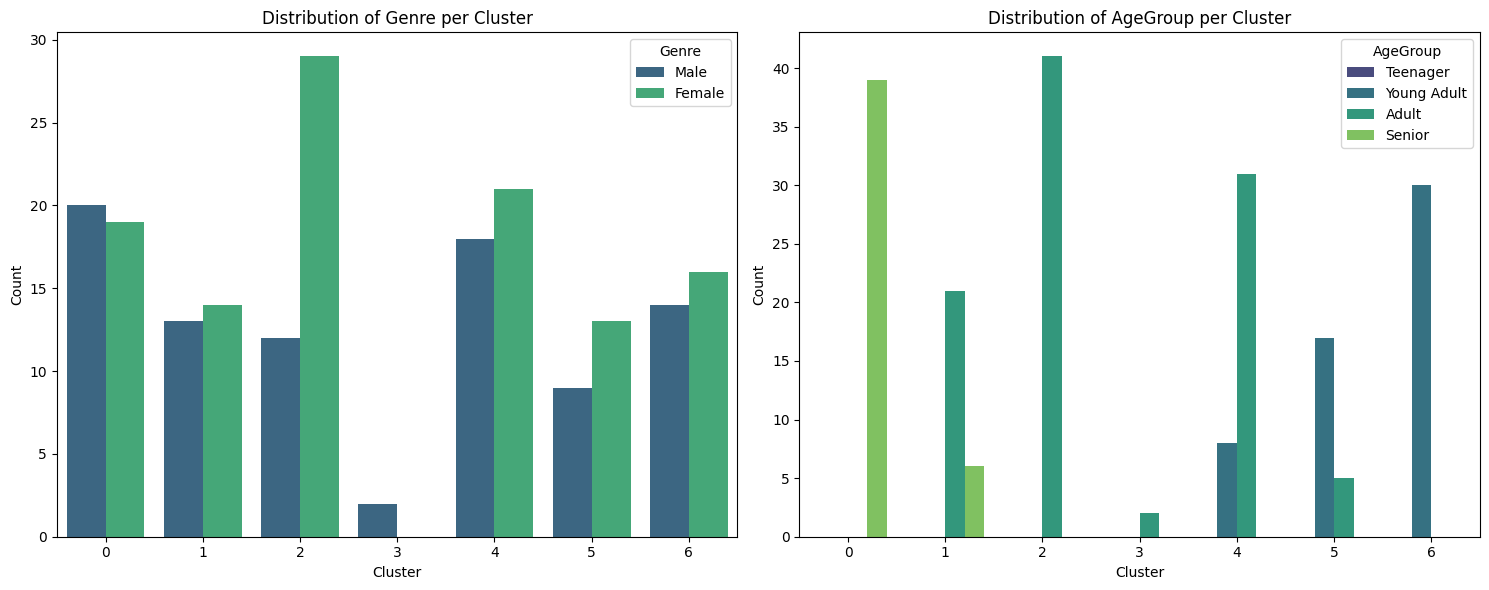

Count plots for categorical features per cluster have been generated.


In [132]:
categorical_features_to_analyze = ['Genre', 'AgeGroup']

plt.figure(figsize=(15, 6))

for i, feature in enumerate(categorical_features_to_analyze):
    plt.subplot(1, 2, i + 1) # Arrange plots side-by-side
    sns.countplot(x='Cluster', hue=feature, data=df_cleaned, palette='viridis')
    plt.title(f'Distribution of {feature} per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(title=feature)

plt.tight_layout()
plt.show()

print("Count plots for categorical features per cluster have been generated.")

### Customer Segment Analysis and Interpretation

Based on the descriptive statistics and visualizations for the 7 clusters identified by the K-Means algorithm, we can characterize each customer segment:

**Cluster 0: Older, Moderate Income & Spending (Age: ~60, Annual Income: ~49k, Spending Score: ~42)**
*   **Numerical:** This segment is characterized by older customers with moderate annual income and moderate spending scores. The `Income_to_Spend` ratio is around 1.76, suggesting their income is somewhat higher than their spending relative to other groups, or their spending is not as impulsive. Their age range is quite tight, with a low standard deviation. Spending and income have moderate variability.
*   **Categorical:** Predominantly Senior (100%), with a relatively balanced gender distribution (approx. 49% Female, 51% Male).
*   **Profile:** Older, financially stable customers who spend moderately and carefully. They are not chasing the latest trends, but are comfortable with their spending habits.

**Cluster 1: High Income, Low Spending (Age: ~44, Annual Income: ~92k, Spending Score: ~19)**
*   **Numerical:** These customers have a high annual income but a very low spending score. Their `Income_to_Spend` ratio is the highest at 5.94, indicating they spend very little relative to their income. They are middle-aged, with moderate variability in age and income, but very low variability in spending score.
*   **Categorical:** Primarily Adults (78%) and some Seniors (22%). Gender distribution is balanced (52% Female, 48% Male).
*   **Profile:** Affluent, often mature customers who are very conservative with their spending. They are likely saving or investing, rather than indulging in discretionary purchases at the mall. They represent a significant untapped potential for luxury or high-value, need-based products.

**Cluster 2: Middle-Aged, Average Income & Spending (Age: ~41, Annual Income: ~45k, Spending Score: ~41)**
*   **Numerical:** This is a large segment of middle-aged customers with average income and average spending scores. The `Income_to_Spend` ratio is around 1.28. There's moderate variability across all numerical features.
*   **Categorical:** Exclusively Adults (100%). Notably, this cluster has a higher proportion of Females (71%) compared to Males (29%).
*   **Profile:** This is the "average" customer segment in terms of income and spending. They are primarily adult women. This group might be responsive to value-for-money offers and general promotions.

**Cluster 3: High Income, Extremely Low Spending (Age: ~35, Annual Income: ~78k, Spending Score: ~1)**
*   **Numerical:** This is a very distinct and small cluster (only 2 members) characterized by high annual income but extremely low spending scores (minimum possible). The `Income_to_Spend` ratio is extremely high at 78, indicating almost no spending relative to income. Their age is around mid-30s.
*   **Categorical:** Consists entirely of Male Adults (100%).
*   **Profile:** These are very high-earning, extremely frugal male customers who almost never spend at the mall. They are likely using their income for investments, essential needs outside the mall, or have other spending priorities. This group is an extreme version of Cluster 1.

**Cluster 4: High Income, High Spending (Age: ~33, Annual Income: ~87k, Spending Score: ~82)**
*   **Numerical:** These customers are young adults with high annual income and very high spending scores. Their `Income_to_Spend` ratio is around 1.07, meaning they spend almost all their income. There is low variability in age and spending score, but moderate in income.
*   **Categorical:** Predominantly Adults (79%) with some Young Adults (21%). Gender distribution is balanced (54% Female, 46% Male).
*   **Profile:** These are the "Big Spenders" or "Shopaholics." They have significant disposable income and are not afraid to use it. They are likely trend-conscious and respond well to new products, fashion, and luxury items. This group is highly valuable.

**Cluster 5: Young, Low Income, High Spending (Age: ~25, Annual Income: ~25k, Spending Score: ~78)**
*   **Numerical:** This segment consists of young customers with low annual income but very high spending scores. Their `Income_to_Spend` ratio is the lowest at 0.33, indicating they spend significantly more than their reported income or are living paycheck to paycheck, possibly with external financial support. There's moderate variability across all numerical features.
*   **Categorical:** Primarily Young Adults (77%), with some Adults (23%). This cluster has a higher proportion of Females (59%) compared to Males (41%).
*   **Profile:** These are often young, impulsive buyers who prioritize spending, possibly on experiences, fashion, or entertainment. They might be students or early in their careers. Marketing efforts could focus on affordable trendy items, credit/financing options, or loyalty programs.

**Cluster 6: Young, Mid-Income, Mid-Spending (Age: ~22, Annual Income: ~59k, Spending Score: ~42)**
*   **Numerical:** This cluster represents very young customers with above-average income and average spending scores. The `Income_to_Spend` ratio is around 2.62, indicating they have some disposable income beyond their spending. Their age range is very tight, suggesting a specific demographic.
*   **Categorical:** Exclusively Young Adults (100%). Gender distribution is balanced (53% Female, 47% Male).
*   **Profile:** This is a segment of young, independent individuals who have a reasonable income and spend moderately. They are likely forming their spending habits and could be influenced by peer trends and digital marketing. There's potential to grow their spending as their income matures.

### Key Takeaways for Business Strategy:

*   **Targeted Marketing:** Each cluster has distinct characteristics, allowing for highly targeted marketing campaigns. For example, Cluster 4 is ideal for luxury goods, while Cluster 5 might respond to budget-friendly trends.
*   **Product Development:** Understanding spending habits can inform product selection. Cluster 1 and 3, with high income but low spending, might be interested in investment opportunities or high-value, durable goods rather than impulsive purchases.
*   **Customer Retention:** Different strategies might be needed for retention. For instance, loyalty programs for high spenders (Cluster 4) and financial advice or budgeting tools for high spenders with low income (Cluster 5).
*   **Identifying Opportunities:** Clusters with high `Income_to_Spend` ratios (1 and 3) represent opportunities to convert dormant wealth into spending, possibly through appealing to their specific values (e.g., quality, sustainability for Cluster 1) or by understanding their non-mall spending habits.
*   **Age-Based Strategies:** The clear age segmentation (Seniors in Cluster 0, Young Adults in Cluster 5 and 6, Adults in 1, 2, 3, 4) suggests that age-specific promotions and store layouts could be effective.